In [ ]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:

drive.mount('/content/drive')
BASE_DRIVE_PATH = '/content/drive/MyDrive/cnn_dataset_split'


TRAIN_DIR = os.path.join(BASE_DRIVE_PATH, 'train')
VAL_DIR = os.path.join(BASE_DRIVE_PATH, 'val')
TEST_DIR = os.path.join(BASE_DRIVE_PATH, 'test')


IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 10
NUM_CLASSES = 4
MODEL_FILE_PATH = 'best_resnet50_damage_model.h5'

print(f"Base Training Path set to: {TRAIN_DIR}")
print(f"Validation Path set to: {VAL_DIR}")
print("\nCheck if the paths above are correct before proceeding.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Base Training Path set to: /content/drive/MyDrive/cnn_dataset_split/train
Validation Path set to: /content/drive/MyDrive/cnn_dataset_split/val

Check if the paths above are correct before proceeding.


In [ ]:
preprocess_fn = resnet_preprocess

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_fn
)


data_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_fn
)

print("Loading Training Data...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("Loading Validation Data...")
validation_generator = data_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("Loading Test Data (for final evaluation)...")
test_generator = data_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
print("\nDetected Class Names:", class_names)

Loading Training Data...
Found 96 images belonging to 4 classes.
Loading Validation Data...
Found 25 images belonging to 4 classes.
Loading Test Data (for final evaluation)...
Found 30 images belonging to 4 classes.

Detected Class Names: ['light_broken', 'moderately_broken', 'no_broken', 'severe_broken']


In [ ]:

def build_resnet50_model(trainable_base=False):

    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_tensor=Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    )

    base_model.trainable = trainable_base

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)


    model = Model(inputs=base_model.input, outputs=predictions)

    return model

model = build_resnet50_model(trainable_base=False)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n--- ResNet50 Model Summary (Base Model Frozen) ---")
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- ResNet50 Model Summary (Base Model Frozen) ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
print("\n--- Phase 1: Feature Extraction Training ---")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(

        filepath=MODEL_FILE_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(

        monitor='val_loss',
        patience=5,
        verbose=1,
        restore_best_weights=True
    )
]

history = model.fit(
    train_generator,
    epochs=INITIAL_EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks
)


--- Phase 1: Feature Extraction Training ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2708 - loss: 2.4379   
Epoch 1: val_accuracy improved from -inf to 0.40000, saving model to best_resnet50_damage_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 41s 10s/step - accuracy: 0.2578 - loss: 2.4223 - val_accuracy: 0.4000 - val_loss: 1.3556
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.3056 - loss: 1.8215
Epoch 2: val_accuracy improved from 0.40000 to 0.76000, saving model to best_resnet50_damage_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.3021 - loss: 1.8193 - val_accuracy: 0.7600 - val_loss: 0.9640
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3142 - loss: 1.7855
Epoch 3: val_accuracy improved from 0.76000 to 0.80000, saving model to best_resnet50_damage_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.3268 - loss: 1.7699 - val_accuracy: 0.8000 - val_loss: 0.8211
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.4826 - loss: 1.4104
Epoch 4: val_accuracy improved from 0.80000 to 0.84000, saving model to best_resnet50_damage_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4818 - loss: 1.4157 - val_accuracy: 0.8400 - val_loss: 0.7279
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5990 - loss: 1.2521
Epoch 5: val_accuracy did not improve from 0.84000
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5898 - loss: 1.2568 - val_accuracy: 0.8400 - val_loss: 0.6816
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5990 - loss: 1.1619
Epoch 6: val_accuracy did not improve from 0.84000
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.6055 - loss: 1.1584 - val_accuracy: 0.8000 - val_loss: 0.6340
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - accuracy: 0.6215 - loss: 0.9450
Epoch 7: val_accuracy did not improve from 0.84000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6198 - loss: 0.9534 - val_accuracy: 0.8400 - val_loss: 0.5760
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 840ms/step - accuracy: 0.6111 - loss: 0.9462
Epoch 8: val_accuracy did not improve from 0.84000
3/3 ━━━━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5521 - loss: 1.0867 - val_accuracy: 0.8800 - val_loss: 0.4984
Epoch 10/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 979ms/step - accuracy: 0.7552 - loss: 0.7914
Epoch 10: val_accuracy did not improve from 0.88000
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7461 - loss: 0.8008 - val_accuracy: 0.8800 - val_loss: 0.4752
Restoring model weights from the end of the best epoch: 10.


In [ ]:
print("\n--- Phase 2: Fine-Tuning ---")

# Load the best weights from Phase 1 before fine-tuning
model.load_weights("/content/best_resnet50_damage_model.h5")

# Unfreeze the model
model.trainable = True

# Re-compile with a very low learning rate (CRITICAL for fine-tuning)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

total_epochs = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # Start from where the previous training left off
    validation_data=validation_generator,
    callbacks=callbacks
)


--- Phase 2: Fine-Tuning ---
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.6736 - loss: 0.8790
Epoch 10: val_accuracy did not improve from 0.88000
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.6745 - loss: 0.8711 - val_accuracy: 0.8800 - val_loss: 0.4974
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 906ms/step - accuracy: 0.6858 - loss: 0.6720
Epoch 11: val_accuracy did not improve from 0.88000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6810 - loss: 0.6823 - val_accuracy: 0.8800 - val_loss: 0.4967
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6458 - loss: 0.8701
Epoch 12: val_accuracy did not improve from 0.88000
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6406 - loss: 0.8770 - val_accuracy: 0.8800 - val_loss: 0.4960
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.6441 - loss: 0.7842
Epoch 13: val_accuracy did not improve from 0.88000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6341 - loss: 0.8063 - val_accuracy: 0.

In [ ]:
print("\n--- Step 6: Final Evaluation on Test Set ---")


model.load_weights("/content/best_resnet50_damage_model.h5")

loss, accuracy = model.evaluate(test_generator)
print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

model.save('final_resnet50_damage_model.h5')
print("\nModel saved as final_resnet50_damage_model.h5. Download this file for your backend.")




--- Step 6: Final Evaluation on Test Set ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.7667 - loss: 0.5168



Test Loss: 0.5168
Test Accuracy: 0.7667

Model saved as final_resnet50_damage_model.h5. Download this file for your backend.


Loading the Keras model...


Model loaded successfully.

Testing image found at: /content/drive/MyDrive/cnn_dataset_split/test/no_broken/Screenshot 2025-12-29 at 10.56.20ΓÇ»AM.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


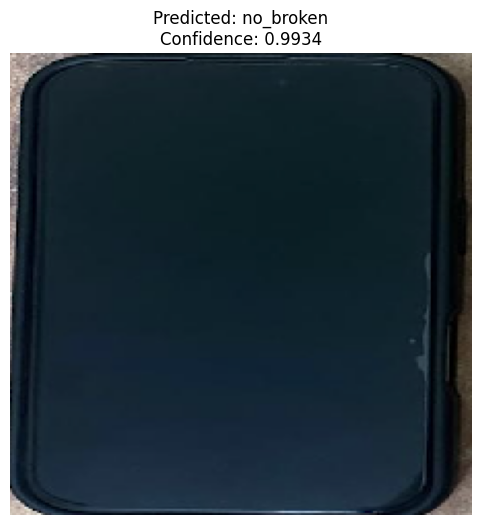

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
import matplotlib.pyplot as plt
import os

MODEL_FILE_PATH = 'final_resnet50_damage_model.h5'
IMAGE_SIZE = (224, 224)
CLASS_MAPPING = {
    0: 'light_broken',
    1: 'moderately_broken',
    2: 'no_broken',
    3: 'severe_broken'
}
TEST_DIR = os.path.join(BASE_DRIVE_PATH, 'test')

try:
    print("Loading the Keras model...")
    final_model = load_model(MODEL_FILE_PATH)
    print("Model loaded successfully.")
except Exception as e:
    print(f"ERROR: Could not load model. Check the file path: {MODEL_FILE_PATH}")
    print(e)
    raise

def predict_single_image(image_path: str):

    img = load_img(image_path, target_size=IMAGE_SIZE)

    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    processed_img = resnet_preprocess(img_array)

    predictions = final_model.predict(processed_img)

    predicted_index = np.argmax(predictions[0])
    predicted_class = CLASS_MAPPING.get(predicted_index, "Unknown")
    confidence = np.max(predictions[0])


    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.4f}")
    plt.axis('off')
    plt.show()

    return predicted_class, confidence
example_image_path = os.path.join(TEST_DIR, 'severe_broken', 'Screenshot 20')

try:
    example_image_path = os.path.join(TEST_DIR, 'no_broken','Screenshot 2025-12-29 at 10.56.20ΓÇ»AM.png')
    print(f"\nTesting image found at: {example_image_path}")
except Exception:
    print("\nCould not automatically find an image. Please manually set 'example_image_path' above.")



if os.path.exists(example_image_path):
    predict_single_image(example_image_path)
else:
    print(f"Error: Image file not found at {example_image_path}")

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as mobilenet_preprocess
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os

IMAGE_SIZE = (224, 224)
print("Creating MobileNetV2 base model...")
base_model = MobileNetV2(
    input_shape=IMAGE_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

MODEL_FILE_PATH = 'best_mobilenetv2_damage_model.h5'
callbacks = [
    ModelCheckpoint(
        filepath=MODEL_FILE_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
]
print("\n--- Phase 1: MobileNetV2 Feature Extraction Training ---")
print(f"Training on {len(train_generator.labels)} samples. Validating on {len(validation_generator.labels)} samples.")

def wrap_mobilenet_preprocess(image):
    return mobilenet_preprocess(image)

history = model.fit(
    train_generator,
    epochs=INITIAL_EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks
)

Creating MobileNetV2 base model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Phase 1: MobileNetV2 Feature Extraction Training ---
Training on 96 samples. Validating on 25 samples.
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.2569 - loss: 1.6865
Epoch 1: val_accuracy improved from -inf to 0.28000, saving model to best_mobilenetv2_damage_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 31s 7s/step - accuracy: 0.2604 - loss: 1.6646 - val_accuracy: 0.2800 - val_loss: 1.3239
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.3247 - loss: 1.5150
Epoch 2: val_accuracy improved from 0.28000 to 0.48000, saving model to best_mobilenetv2_damage_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.3190 - loss: 1.5169 - val_accuracy: 0.4800 - val_loss: 1.2477
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3455 - loss: 1.5112
Epoch 3: val_accuracy improved from 0.48000 to 0.56000, saving model to best_mobilenetv2_damage_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.3503 - loss: 1.5064 - val_accuracy: 0.5600 - val_loss: 1.1910
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 838ms/step - accuracy: 0.2674 - loss: 1.5326
Epoch 4: val_accuracy improved from 0.56000 to 0.60000, saving model to best_mobilenetv2_damage_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.2839 - loss: 1.5150 - val_accuracy: 0.6000 - val_loss: 1.1356
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 0.4566 - loss: 1.2895
Epoch 5: val_accuracy did not improve from 0.60000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4544 - loss: 1.2909 - val_accuracy: 0.5600 - val_loss: 1.0892
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.4115 - loss: 1.2682
Epoch 6: val_accuracy did not improve from 0.60000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4102 - loss: 1.2580 - val_accuracy: 0.6000 - val_loss: 1.0594
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.4253 - loss: 1.2047
Epoch 7: val_accuracy did not improve from 0.60000
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.4310 - loss: 1.2078 - val_accuracy: 0.5600 - val_loss: 1.0341
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.5087 - loss: 1.1353
Epoch 8: val_accuracy did not improve from 0.60000
3/3 ━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5326 - loss: 1.0240 - val_accuracy: 0.6400 - val_loss: 0.9416


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
import os

MODEL_FILE_PATH = 'best_mobilenetv2_damage_model.h5'
INITIAL_EPOCHS = 10
FINE_TUNE_EPOCHS = 10
total_epochs = INITIAL_EPOCHS + FINE_TUNE_EPOCHS

print("Loading best weights from Phase 1...")
model = load_model(MODEL_FILE_PATH)

print("Unfreezing MobileNetV2 base model for fine-tuning...")

model.trainable = True

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_fine_tune = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=MODEL_FILE_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        restore_best_weights=True
    )
]

print(f"\n--- Phase 2: MobileNetV2 Fine-Tuning (Epochs 11 to {total_epochs}) ---")

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=10,
    validation_data=validation_generator,
    callbacks=callbacks_fine_tune
)

Loading best weights from Phase 1...


Unfreezing MobileNetV2 base model for fine-tuning...

--- Phase 2: MobileNetV2 Fine-Tuning (Epochs 11 to 20) ---
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - accuracy: 0.5990 - loss: 0.9810
Epoch 11: val_accuracy improved from -inf to 0.64000, saving model to best_mobilenetv2_damage_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5898 - loss: 1.0015 - val_accuracy: 0.6400 - val_loss: 0.9410
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - accuracy: 0.4740 - loss: 1.0878
Epoch 12: val_accuracy did not improve from 0.64000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4805 - loss: 1.0783 - val_accuracy: 0.5600 - val_loss: 0.9435
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3941 - loss: 1.1473   
Epoch 13: val_accuracy did not improve from 0.64000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4076 - loss: 1.1382 - val_accuracy: 0.5600 - val_loss: 0.9452
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 886ms/step - accuracy: 0.4861 - loss: 1.2040
Epoch 14: val_accuracy did not improve from 0.64000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.4870 - loss: 1.1967 - val_accuracy: 0.5600 - val_loss: 0.9459
Epoch 15/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.6111 - loss: 1.0490
Epoch 15: val_accuracy did not improve from 0.64000
3/3

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
import os

MODEL_FILE_PATH = 'best_mobilenetv2_damage_model.h5'
TEST_MODEL_FILE_PATH = 'final_mobilenetv2_damage_model.h5'

print("\n--- Step 6: MobileNetV2 Final Evaluation on Test Set ---")
try:
    model = load_model(MODEL_FILE_PATH)
except Exception as e:
    print(f"Error loading model: {e}")
    raise

loss, accuracy = model.evaluate(test_generator)
print(f"\nMobileNetV2 Test Loss: {loss:.4f}")
print(f"MobileNetV2 Test Accuracy: {accuracy:.4f}")

model.save(TEST_MODEL_FILE_PATH)
print(f"\nModel saved as {TEST_MODEL_FILE_PATH}. Download this file for your backend.")


--- Step 6: MobileNetV2 Final Evaluation on Test Set ---


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.7000 - loss: 0.8518



MobileNetV2 Test Loss: 0.8518
MobileNetV2 Test Accuracy: 0.7000

Model saved as final_mobilenetv2_damage_model.h5. Download this file for your backend.
